In [1]:
# Python Library dependencies (include jax, neural_tangents)
# note that there are two numpy lib (onp - standard numpy library // np - Jax competible autodiff implmentation of numpy)
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import time
from absl import app
from absl import flags

import jax 
import jax.numpy as np
import neural_tangents as nt
from neural_tangents import stax
from examples import datasets
from examples import util
from neural_tangents.utils.kernel import Kernel
import numpy as onp
from jax import random
from jax.config import config ; config.update('jax_enable_x64', True)
import util
from util import Prod

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# GPU device check
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Varifold Classification example

Here, we compute ``neural varifold`` using Charon-Trouve style kernel on NTK (neural tangent kernel) 

$\Theta_{varifold} = \Theta_{position} \otimes \Theta_{normal}$

This is called ``neural'' because NTK is equivalent to training infinite-width neural network with MSE (L2) loss. 
We are going to demonstrate its capability of classification on ModelNet10 dataset. First of all, we are going to load ModelNet10 dataset (3991 train // 908 test data)

In [2]:
# define data parameter setting 
n_pts = 1024 # number of points 
onp.random.seed(0) # random seed for numpy
sample_size = 1

# Load the dataset
data = onp.load('./modelnet/modelnet10_1024_core3.npz')

Training on ModelNet10 is computationally costly as the computational costs of the kernel is quatratic with respect to the size of data (3991//908). 

* In this demo, we are going to reduce the size of training data by random subsampling 10 examples per each class (i.e. training data size = 100)
* We are going to retain all test data (test data size = 908). 
* note that test data size shown below is 920. It is because input data size must be decimal for GPU parallel batch processing. So we duplicate the orignial test data (908) to fit the size requirement. 

In [3]:
# first - train dataset
x_train = data['x_train'][:3991]
y_train = data['y_train'][:3991]    
y_label = np.argmax(y_train,axis=-1)

# subsample training data  
new_train = []
new_label = []
new_graph = []
for i in range(10):
    idx = onp.argwhere(y_label==i)[:,0]
    sample = onp.random.choice(len(idx),sample_size,replace=False)
    new_train.append(x_train[idx[sample]])
    new_label.append(y_train[idx[sample]])
    #new_graph.append( graph1[idx[sample]])

# train data
x_train = onp.concatenate(new_train,0)
y_train = onp.concatenate(new_label,0)

# test (note that it is actually 908 samples + duplication to fit hardward requirement)
x_test = data['x_test']
y_test = data['y_test'] 

print(x_train.shape)
print(x_test.shape)

(10, 1024, 6)
(920, 1024, 6)


One can see that train/test data are tensor of $sample size \times point size \times 6$, 
where, sample size is the size of train/test samples, and point size is the number of points representing individual shapes.


In this experiment, each sample has 1024 points with 6 features. 

* First three features are $x,y,z$ positional coordinates 
* Last three features are corresponding unit normal coordinates $nx,ny,nz$. 


In order to feed the above data into the neural varifold kernel, we are going to reshape the tensor as $ sample size \times point size \times 2 \times 3$

In [4]:
x_train = x_train.reshape(sample_size*10,n_pts,2,3).transpose((0,2,1,3))
x_test  = x_test.reshape(920,n_pts,2,3).transpose((0,2,1,3))

print(x_train.shape)
print(x_test.shape)

(10, 2, 1024, 3)
(920, 2, 1024, 3)


In order to show an example of the train/test data. We are going to plot a sample from each class in the training data

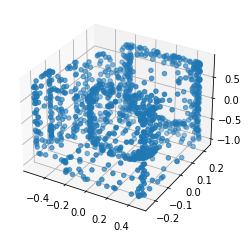

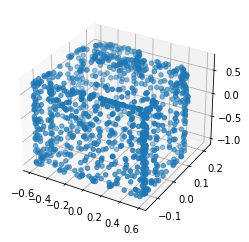

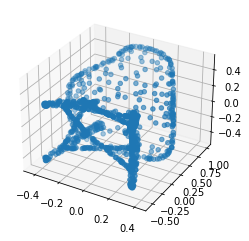

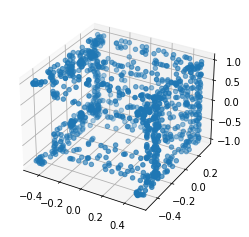

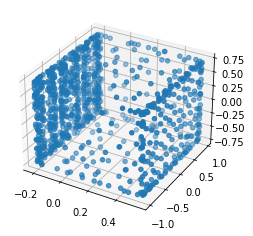

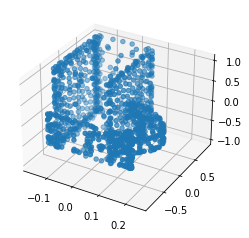

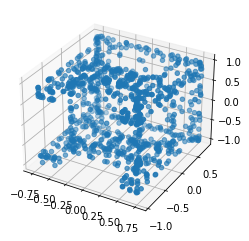

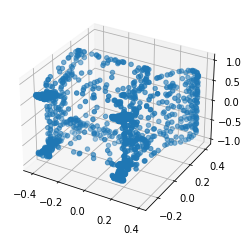

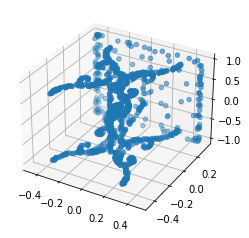

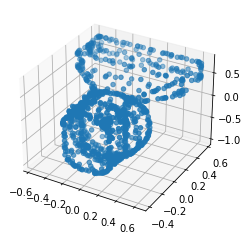

In [5]:
# plot a sample from each class in the training data 
for i in range(10):
    sample = x_train[i*sample_size+0,0].squeeze()
    ax = plt.axes(projection='3d')
    ax.scatter(sample[:,0],sample[:,1],sample[:,2])
    plt.show()

We are going to build an infinite-width neural network using ``neural_tangent`` library. 

In this example, we are going to use PointNet like architecture with LayerNorm and Global Average Pooling (GAP). 

``stax.Dense`` function has three key parameters ``p1`` = number of channels, ``p2`` = weight initialisation parameter, ``p3`` = bias initialisation parameter.

* ``p1``: since we are using infinite-width, we just set the number of channels does not matter. In this example, we set it as 1 
* ``p2``: In many NTK literature, it is usually bounded between 1 ~ 2. Here, we set it as 1 for the simplicity. 
* ``p3``: In many NTK liternature, its value has usually a value around 0.0 ~ 0.1. Here, we set it as 100. Surprisingly it works much better for NTK. 


``stax.Conv`` function has 6 key parameters in our case. ``p1`` = number of channels, ``p2`` = 2D convolution window, ``p3`` = padding, ``p4`` = convolution method (either valid or same), ``p5`` = weight initialisation parameter, ``p6`` = bias initialisation parameter 

* ``p1``: Just like ``stax.Dense`` infinite-width cases, channel size does not really matter. We set it as 1. 
* ``p2``: The convolution window size is (1,1) Given Our data input dimension (num_batch_size X num_point_size X 2 X 3), 1 X 1 convolution is doing 1D convolution on position and its normal separately. 
* ``p3``: We don't use padding. i.e. (1,1). 
* ``p4``: Since we are using (1,1) convolution either valid or same methods return the same output. 
* ``p5`` and ``p6``: we are using the same parameters as the ``stax.Dense``.  

``init_fn``, ``apply_fn`` and ``kernel_fn`` are correponding to initialisation, finite-width NN, NTK representation of the infinite-width neural network (In this experiment)

``Prod`` does the element-wise product between position and normal kernel  $\Theta_{position} \otimes \Theta_{normal}$

``stax.GlobalAvgPool`` compute a varifold norm by averaging the elements of the kernel. 

In [6]:
# Build the 5-layer infinite network.
layers = []
for k in range(5):
    layers += [stax.Dense(1, 1., 0.05),stax.LayerNorm(), stax.Relu()] # PointNet like architecture with fully connected layer
    #layers += [stax.Conv(1, (1,1), (1,1), 'SAME', 1., 0.05),stax.LayerNorm(), stax.Relu()] # PointNet like architecture with pointwise convolution
print(len(layers)//3, '-layer network')
init_fn, apply_fn, kernel_fn = stax.serial(*(layers + [Prod(),stax.GlobalAvgPool()])) # element-wise product to compute varifold kernel, then compute average to get a norm 

# compute the kernel in batches, in parallel.
kernel_fn = nt.batch(kernel_fn,device_count=-1,batch_size=5)


5 -layer network


Like traditional kernel methods, NTK forms Gram Matrices between training data $K_{(train,train)}$ and training & testing data $K_{(test,train)}$

Given two gram matrices, shape classification can be reformulated as a kernel regression problem. 

``gradient_descent_mse_ensemble`` function computes the kernel regression with a diagional regularisation parameter $\lambda$. In this experiment, we set it as 1e-2

\begin{equation}
Y_{test} = K_{(test,train)}  (K_{(train,train)} + \lambda I )^{-1}  Y_{train}
\end{equation}

where, $Y_{train}$ and $Y_{test}$ are ground truth label for train and test data, respectively. 

In [7]:
# conduct kernel regression with diagonal regularisation (1e-2)
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, x_train,y_train, diag_reg=1e-2) # train a function
fx_test_nngp, fx_test_ntk = predict_fn(x_test=x_test) # regression on the test dataset
fx_test_nngp.block_until_ready()
fx_test_ntk.block_until_ready()

DeviceArray([[ 0.27960626, -0.07819518,  0.19814683, ...,  0.22488994,
               0.15375266,  0.22682444],
             [ 0.55182986, -0.00190455, -0.07803222, ...,  0.06739823,
              -0.00872504,  0.01994867],
             [ 0.56990261,  0.00232326,  0.03350264, ...,  0.02668818,
               0.1999432 ,  0.07238856],
             ...,
             [ 0.2763447 , -0.08770236,  0.09419284, ...,  0.09745385,
               0.16619116,  0.04721926],
             [ 0.10176534,  0.28442956,  0.23545348, ...,  0.14253469,
              -0.07510579,  0.0643707 ],
             [ 0.27263992, -0.0568905 ,  0.1427002 , ...,  0.21469803,
               0.00766582,  0.15745635]], dtype=float64)

Note that NTK technique is equivalent with training corresponding infinite-width neural network with MSE (L2) loss. 
Here, we are going to compute MSE loss and its classification accuracy.

In [8]:
# Print out accuracy and loss for infinite network predictions.
loss = lambda fx, y_hat: 0.5 * np.mean((fx - y_hat) ** 2)
util.print_summary('NNGP test', y_test[:908], fx_test_nngp[:908], None, loss)
util.print_summary('NTK  test', y_test[:908], fx_test_ntk[:908] , None, loss)


Evaluating Network on NNGP test data.
---------------------------------------
Network Accuracy = 0.4889867841409692
Network Loss = 0.035137528454013946
---------------------------------------

Evaluating Network on NTK  test data.
---------------------------------------
Network Accuracy = 0.5649779735682819
Network Loss = 0.03358055810091546
---------------------------------------
